# Install dependencies

In [81]:
!pip install -q datasets transformers evaluate wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


# Log in first since the dataset is gated

In [2]:
from huggingface_hub import notebook_login

notebook_login()

# Dataset loading

In [3]:
sidewalk_dataset_identifier = "segments/sidewalk-semantic"

In [4]:
from datasets import load_dataset

dataset = load_dataset(sidewalk_dataset_identifier)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.26k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/324M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1000
    })
})

# Split into train and test sets

In [6]:
dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [7]:
image = train_ds[0]
image

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080>}

## Let's visualize one example  (TODO)



In [9]:
print(image['label'])

<PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080 at 0x7F8AB04A8DC0>


In [18]:
import json
from huggingface_hub import hf_hub_download

filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=sidewalk_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print("Id2label:", id2label)

id2label.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

Id2label: {0: 'unlabeled', 1: 'flat-road', 2: 'flat-sidewalk', 3: 'flat-crosswalk', 4: 'flat-cyclinglane', 5: 'flat-parkingdriveway', 6: 'flat-railtrack', 7: 'flat-curb', 8: 'human-person', 9: 'human-rider', 10: 'vehicle-car', 11: 'vehicle-truck', 12: 'vehicle-bus', 13: 'vehicle-tramtrain', 14: 'vehicle-motorcycle', 15: 'vehicle-bicycle', 16: 'vehicle-caravan', 17: 'vehicle-cartrailer', 18: 'construction-building', 19: 'construction-door', 20: 'construction-wall', 21: 'construction-fenceguardrail', 22: 'construction-bridge', 23: 'construction-tunnel', 24: 'construction-stairs', 25: 'object-pole', 26: 'object-trafficsign', 27: 'object-trafficlight', 28: 'nature-vegetation', 29: 'nature-terrain', 30: 'sky', 31: 'void-ground', 32: 'void-dynamic', 33: 'void-static', 34: 'void-unclear'}


In [20]:
sidewalk_palette = [
  [0, 0, 0], # unlabeled
  [216, 82, 24], # flat-road
  [255, 255, 0], # flat-sidewalk
  [125, 46, 141], # flat-crosswalk
  [118, 171, 47], # flat-cyclinglane
  [161, 19, 46], # flat-parkingdriveway
  [255, 0, 0], # flat-railtrack
  [0, 128, 128], # flat-curb
  [190, 190, 0], # human-person
  [0, 255, 0], # human-rider
  [0, 0, 255], # vehicle-car
  [170, 0, 255], # vehicle-truck
  [84, 84, 0], # vehicle-bus
  [84, 170, 0], # vehicle-tramtrain
  [84, 255, 0], # vehicle-motorcycle
  [170, 84, 0], # vehicle-bicycle
  [170, 170, 0], # vehicle-caravan
  [170, 255, 0], # vehicle-cartrailer
  [255, 84, 0], # construction-building
  [255, 170, 0], # construction-door
  [255, 255, 0], # construction-wall
  [33, 138, 200], # construction-fenceguardrail
  [0, 170, 127], # construction-bridge
  [0, 255, 127], # construction-tunnel
  [84, 0, 127], # construction-stairs
  [84, 84, 127], # object-pole
  [84, 170, 127], # object-trafficsign
  [84, 255, 127], # object-trafficlight
  [170, 0, 127], # nature-vegetation
  [170, 84, 127], # nature-terrain
  [170, 170, 127], # sky
  [170, 255, 127], # void-ground
  [255, 0, 127], # void-dynamic
  [255, 84, 127], # void-static
  [255, 170, 127], # void-unclear
]

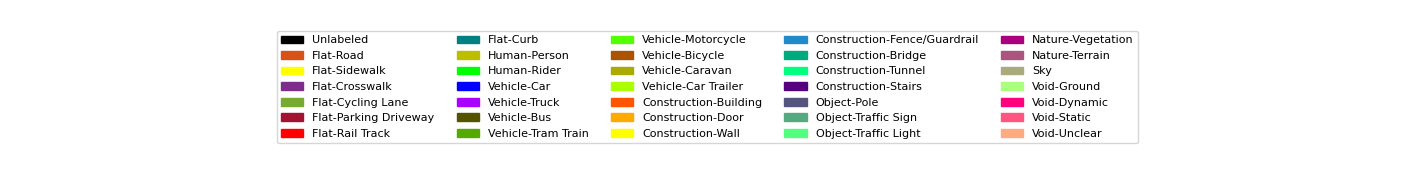

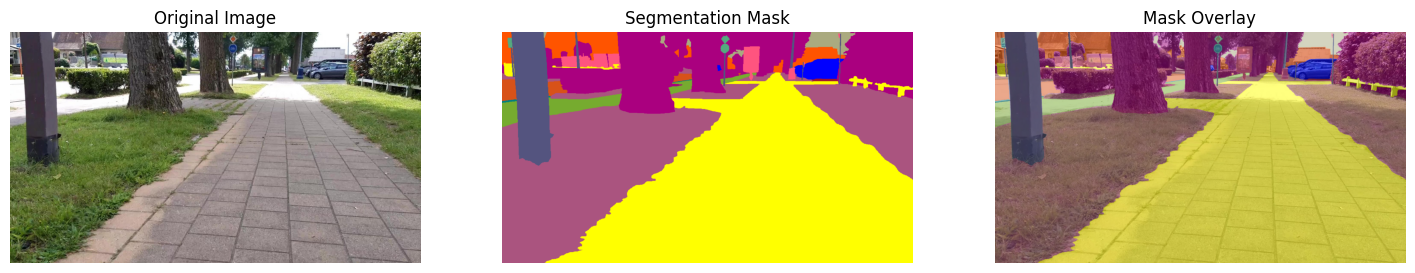

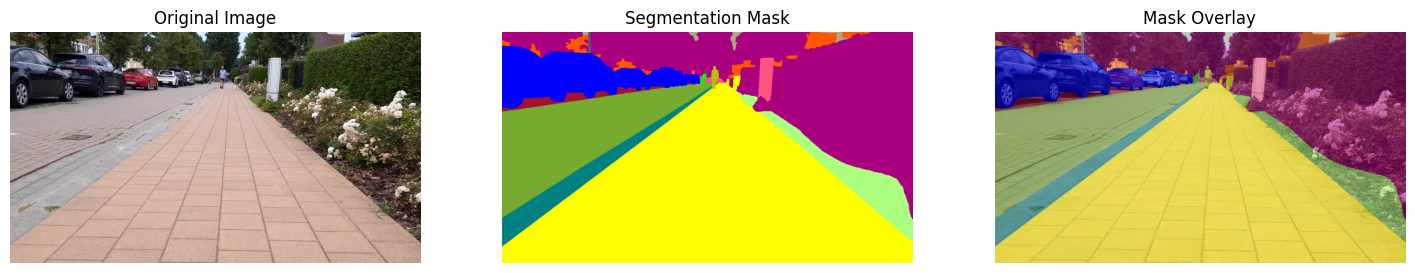

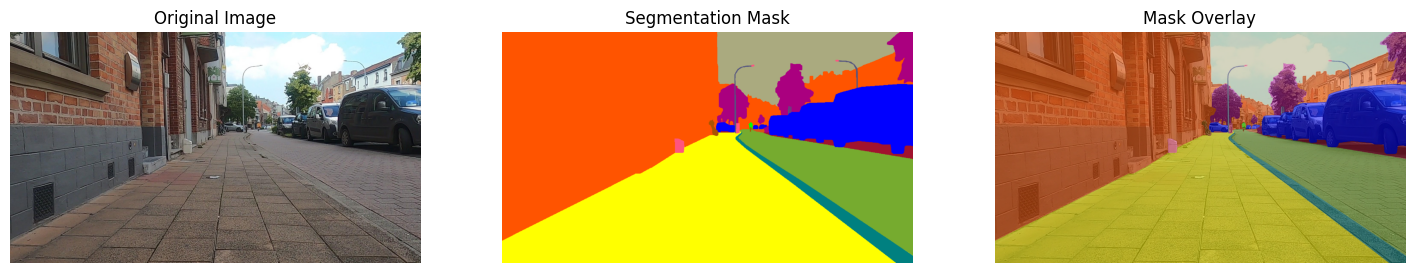

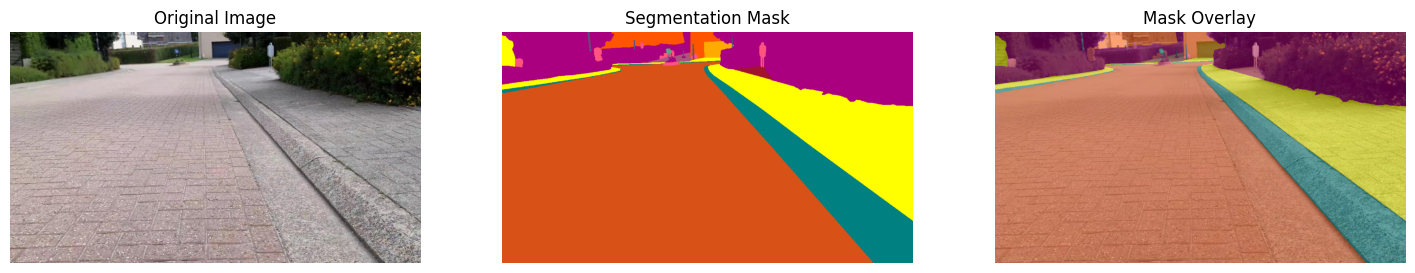

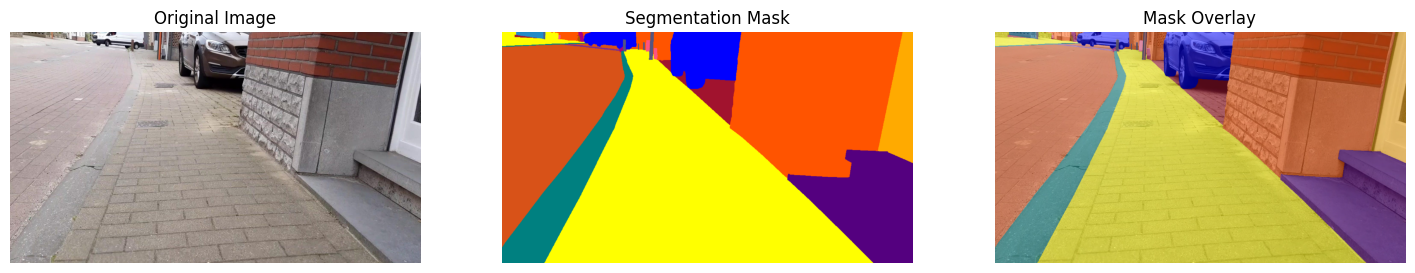

In [73]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches

# Create and show the legend separately
fig, ax = plt.subplots(figsize=(18, 2))

legend_patches = [patches.Patch(color=np.array(color)/255, label=label) for label, color in zip(id2label.values(), sidewalk_palette)]

ax.legend(handles=legend_patches, loc='center', bbox_to_anchor=(0.5, 0.5), ncol=5, fontsize=8)
ax.axis('off')

plt.show()

for i in range(5):
    image = train_ds[i]

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Show the original image
    ax[0].imshow(image['pixel_values'])
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    mask_np = np.array(image['label'])

    # Create a new empty RGB image
    colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    # Assign colors to each value in the mask
    for label_id, color in enumerate(sidewalk_palette):
        colored_mask[mask_np == label_id] = color

    colored_mask_img = Image.fromarray(colored_mask, 'RGB')

    # Show the segmentation mask
    ax[1].imshow(colored_mask_img)
    ax[1].set_title('Segmentation Mask')
    ax[1].axis('off')

    # Convert the original image to RGBA to support transparency
    image_rgba = image['pixel_values'].convert("RGBA")
    colored_mask_rgba = colored_mask_img.convert("RGBA")

    # Adjust transparency of the mask
    alpha = 128  # Transparency level (0 fully transparent, 255 fully opaque)
    image_2_with_alpha = Image.new("RGBA", colored_mask_rgba.size)
    for x in range(colored_mask_rgba.width):
        for y in range(colored_mask_rgba.height):
            r, g, b, a = colored_mask_rgba.getpixel((x, y))
            image_2_with_alpha.putpixel((x, y), (r, g, b, alpha))

    superposed = Image.alpha_composite(image_rgba, image_2_with_alpha)

    # Show the mask overlay
    ax[2].imshow(superposed)
    ax[2].set_title('Mask Overlay')
    ax[2].axis('off')

    plt.show()


# Visualize class ocurrences

In [54]:
import matplotlib.pyplot as plt
import numpy as np

class_counts = np.zeros(len(id2label))

for example in train_ds:
    mask_np = np.array(example['label'])
    unique, counts = np.unique(mask_np, return_counts=True)
    for u, c in zip(unique, counts):
        class_counts[u] += c

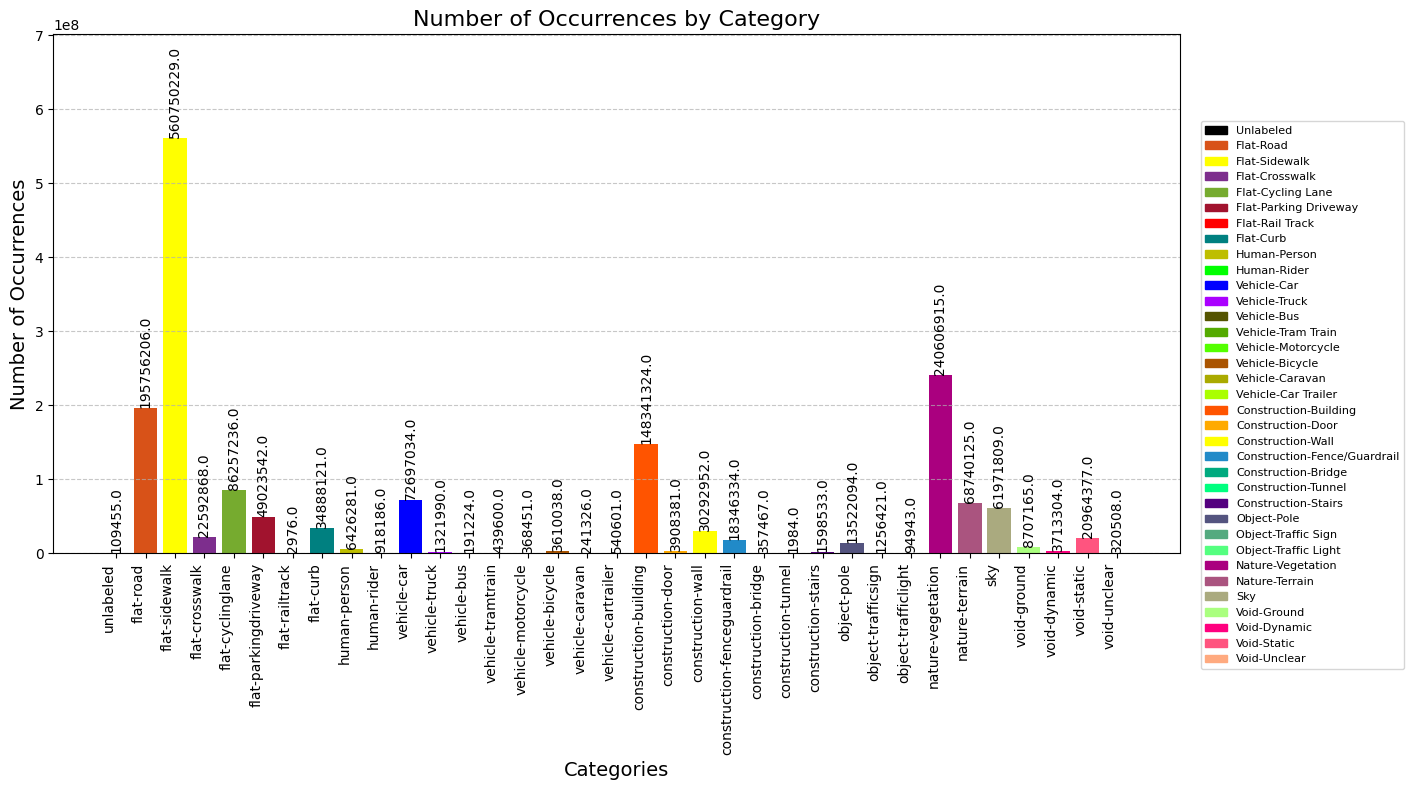

In [78]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import patches

# Normalize colors to be in the range [0, 1]
normalized_palette = [tuple(c / 255 for c in color) for color in sidewalk_palette]

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(range(len(labels)), class_counts, color=[normalized_palette[i] for i in range(len(labels))])

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, ha="right")

ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Number of Occurrences", fontsize=14)
ax.set_title("Number of Occurrences by Category", fontsize=16)

ax.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust the y-axis limit
y_max = max(class_counts)
ax.set_ylim(0, y_max * 1.25)

for bar in bars:
    height = bar.get_height()
    offset = 10  # Adjust this value as needed
    ax.text(bar.get_x() + bar.get_width() / 2.0, height + offset, f"{height}",
            ha="center", va="bottom", rotation=90, fontsize=10, color='black')

fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=8)  # Adjust ncol as needed

plt.tight_layout()
plt.show()


# Add data augmentation and init image processor

In [79]:
from torchvision.transforms import ColorJitter
from transformers import SegformerImageProcessor


processor = SegformerImageProcessor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Init model from checkpoint

In [80]:
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 # Set training arguments and connect to Weights & biases

In [54]:
from transformers import TrainingArguments

epochs = 50
lr = 0.00006
batch_size = 2

hub_model_id = "segformer-b0-segments-sidewalk-finetuned"

training_args = TrainingArguments(
    "segformer-b0-segments-sidewalk-finetuned",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
    report_to="wandb"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import wandb

wandb.init(
    project="segformer-b0-segments-sidewalk-finetuned",  # change this
    name="segformer-b0-segments-sidewalk-finetuned",  # change this
    config=training_args,
)

## Set custom compute_metrics for better logging

In [57]:
import torch
from torch import nn
import evaluate
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=processor.do_reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

In [59]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [60]:
trainer.train()

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Unlabeled,Accuracy Flat-road,Accuracy Flat-sidewalk,Accuracy Flat-crosswalk,Accuracy Flat-cyclinglane,Accuracy Flat-parkingdriveway,Accuracy Flat-railtrack,Accuracy Flat-curb,Accuracy Human-person,Accuracy Human-rider,Accuracy Vehicle-car,Accuracy Vehicle-truck,Accuracy Vehicle-bus,Accuracy Vehicle-tramtrain,Accuracy Vehicle-motorcycle,Accuracy Vehicle-bicycle,Accuracy Vehicle-caravan,Accuracy Vehicle-cartrailer,Accuracy Construction-building,Accuracy Construction-door,Accuracy Construction-wall,Accuracy Construction-fenceguardrail,Accuracy Construction-bridge,Accuracy Construction-tunnel,Accuracy Construction-stairs,Accuracy Object-pole,Accuracy Object-trafficsign,Accuracy Object-trafficlight,Accuracy Nature-vegetation,Accuracy Nature-terrain,Accuracy Sky,Accuracy Void-ground,Accuracy Void-dynamic,Accuracy Void-static,Accuracy Void-unclear,Iou Unlabeled,Iou Flat-road,Iou Flat-sidewalk,Iou Flat-crosswalk,Iou Flat-cyclinglane,Iou Flat-parkingdriveway,Iou Flat-railtrack,Iou Flat-curb,Iou Human-person,Iou Human-rider,Iou Vehicle-car,Iou Vehicle-truck,Iou Vehicle-bus,Iou Vehicle-tramtrain,Iou Vehicle-motorcycle,Iou Vehicle-bicycle,Iou Vehicle-caravan,Iou Vehicle-cartrailer,Iou Construction-building,Iou Construction-door,Iou Construction-wall,Iou Construction-fenceguardrail,Iou Construction-bridge,Iou Construction-tunnel,Iou Construction-stairs,Iou Object-pole,Iou Object-trafficsign,Iou Object-trafficlight,Iou Nature-vegetation,Iou Nature-terrain,Iou Sky,Iou Void-ground,Iou Void-dynamic,Iou Void-static,Iou Void-unclear
20,3.209300,3.273747,0.074350,0.121680,0.583101,nan,0.262243,0.910279,0.041092,0.057517,0.004092,nan,0.000402,0.000000,0.000000,0.701812,0.000000,0.000000,0.000000,0.000000,0.037667,0.000000,0.000000,0.863288,0.000000,0.000000,0.000000,0.000000,nan,0.004287,0.000000,0.000000,0.000000,0.859738,0.002435,0.140375,0.001685,0.000000,0.006839,0.000000,0.000000,0.222090,0.627404,0.035512,0.041200,0.003964,0.000000,0.000400,0.000000,0.000000,0.525376,0.000000,0.000000,0.000000,0.000000,0.036202,0.000000,0.000000,0.375686,0.000000,0.000000,0.000000,0.000000,0.000000,0.002392,0.000000,0.000000,0.000000,0.592865,0.002414,0.129633,0.001583,0.000000,0.005528,0.000000
40,2.807800,2.549243,0.085484,0.136165,0.617166,nan,0.230510,0.942931,0.009882,0.002028,0.001305,nan,0.000281,0.000000,0.000000,0.853683,0.000000,0.000000,0.000000,0.000000,0.000089,0.000000,0.000000,0.810921,0.000000,0.000001,0.000000,0.000000,nan,0.000000,0.000023,0.000000,0.000000,0.954099,0.000004,0.550286,0.000000,0.000000,0.001236,0.000000,0.000000,0.188541,0.602494,0.009468,0.001988,0.001300,0.000000,0.000280,0.000000,0.000000,0.535058,0.000000,0.000000,0.000000,0.000000,0.000089,0.000000,0.000000,0.478071,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000023,0.000000,0.000000,0.640574,0.000004,0.532847,0.000000,0.000000,0.001218,0.000000
60,2.283300,2.126398,0.103539,0.152664,0.657046,nan,0.682067,0.881010,0.000788,0.002101,0.002924,nan,0.000000,0.000000,0.000000,0.775187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.820988,0.000000,0.000076,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.972281,0.000247,0.747436,0.000000,0.000000,0.000155,0.000000,nan,0.388695,0.697024,0.000785,0.002059,0.002897,nan,0.000000,0.000000,0.000000,0.554902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.495031,0.000000,0.000076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.630674,0.000247,0.644238,0.000000,0.000000,0.000155,0.000000
80,2.047600,1.937773,0.112901,0.159471,0.672877,nan,0.686622,0.902503,0.000000,0.028153,0.002501,nan,0.000000,0.000000,0.000000,0.889776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.838025,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.960140,0.002992,0.792312,0.000000,0.000000,0.000052,0.000000,nan,0.401205,0.708930,0.000000,0.027507,0.002483,

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encoun

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Unlabeled,Accuracy Flat-road,Accuracy Flat-sidewalk,Accuracy Flat-crosswalk,Accuracy Flat-cyclinglane,Accuracy Flat-parkingdriveway,Accuracy Flat-railtrack,Accuracy Flat-curb,Accuracy Human-person,Accuracy Human-rider,Accuracy Vehicle-car,Accuracy Vehicle-truck,Accuracy Vehicle-bus,Accuracy Vehicle-tramtrain,Accuracy Vehicle-motorcycle,Accuracy Vehicle-bicycle,Accuracy Vehicle-caravan,Accuracy Vehicle-cartrailer,Accuracy Construction-building,Accuracy Construction-door,Accuracy Construction-wall,Accuracy Construction-fenceguardrail,Accuracy Construction-bridge,Accuracy Construction-tunnel,Accuracy Construction-stairs,Accuracy Object-pole,Accuracy Object-trafficsign,Accuracy Object-trafficlight,Accuracy Nature-vegetation,Accuracy Nature-terrain,Accuracy Sky,Accuracy Void-ground,Accuracy Void-dynamic,Accuracy Void-static,Accuracy Void-unclear,Iou Unlabeled,Iou Flat-road,Iou Flat-sidewalk,Iou Flat-crosswalk,Iou Flat-cyclinglane,Iou Flat-parkingdriveway,Iou Flat-railtrack,Iou Flat-curb,Iou Human-person,Iou Human-rider,Iou Vehicle-car,Iou Vehicle-truck,Iou Vehicle-bus,Iou Vehicle-tramtrain,Iou Vehicle-motorcycle,Iou Vehicle-bicycle,Iou Vehicle-caravan,Iou Vehicle-cartrailer,Iou Construction-building,Iou Construction-door,Iou Construction-wall,Iou Construction-fenceguardrail,Iou Construction-bridge,Iou Construction-tunnel,Iou Construction-stairs,Iou Object-pole,Iou Object-trafficsign,Iou Object-trafficlight,Iou Nature-vegetation,Iou Nature-terrain,Iou Sky,Iou Void-ground,Iou Void-dynamic,Iou Void-static,Iou Void-unclear
20,3.209300,3.273747,0.074350,0.121680,0.583101,nan,0.262243,0.910279,0.041092,0.057517,0.004092,nan,0.000402,0.000000,0.000000,0.701812,0.000000,0.000000,0.000000,0.000000,0.037667,0.000000,0.000000,0.863288,0.000000,0.000000,0.000000,0.000000,nan,0.004287,0.000000,0.000000,0.000000,0.859738,0.002435,0.140375,0.001685,0.000000,0.006839,0.000000,0.000000,0.222090,0.627404,0.035512,0.041200,0.003964,0.000000,0.000400,0.000000,0.000000,0.525376,0.000000,0.000000,0.000000,0.000000,0.036202,0.000000,0.000000,0.375686,0.000000,0.000000,0.000000,0.000000,0.000000,0.002392,0.000000,0.000000,0.000000,0.592865,0.002414,0.129633,0.001583,0.000000,0.005528,0.000000
40,2.807800,2.549243,0.085484,0.136165,0.617166,nan,0.230510,0.942931,0.009882,0.002028,0.001305,nan,0.000281,0.000000,0.000000,0.853683,0.000000,0.000000,0.000000,0.000000,0.000089,0.000000,0.000000,0.810921,0.000000,0.000001,0.000000,0.000000,nan,0.000000,0.000023,0.000000,0.000000,0.954099,0.000004,0.550286,0.000000,0.000000,0.001236,0.000000,0.000000,0.188541,0.602494,0.009468,0.001988,0.001300,0.000000,0.000280,0.000000,0.000000,0.535058,0.000000,0.000000,0.000000,0.000000,0.000089,0.000000,0.000000,0.478071,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000023,0.000000,0.000000,0.640574,0.000004,0.532847,0.000000,0.000000,0.001218,0.000000
60,2.283300,2.126398,0.103539,0.152664,0.657046,nan,0.682067,0.881010,0.000788,0.002101,0.002924,nan,0.000000,0.000000,0.000000,0.775187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.820988,0.000000,0.000076,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.972281,0.000247,0.747436,0.000000,0.000000,0.000155,0.000000,nan,0.388695,0.697024,0.000785,0.002059,0.002897,nan,0.000000,0.000000,0.000000,0.554902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.495031,0.000000,0.000076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.630674,0.000247,0.644238,0.000000,0.000000,0.000155,0.000000
80,2.047600,1.937773,0.112901,0.159471,0.672877,nan,0.686622,0.902503,0.000000,0.028153,0.002501,nan,0.000000,0.000000,0.000000,0.889776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.838025,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.960140,0.002992,0.792312,0.000000,0.000000,0.000052,0.000000,nan,0.401205,0.708930,0.000000,0.027507,0.002483,

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encoun

KeyboardInterrupt: 

## Test how the model behaves

# Evaluate against test set

# Access it using the inference API and visualize results (TODO)

In [ ]:
import requests
from transformers import pipeline
import numpy as np
from PIL import Image, ImageDraw

url = "https://upload.wikimedia.org/wikipedia/commons/6/64/Ejemplo.png"

image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient()
response = client.object_detection(
    model="sergiopaniego/detr-resnet-50-dc5-fashionpedia-finetuned",
    image='https://upload.wikimedia.org/wikipedia/commons/6/64/Ejemplo.png'
)

print(response)

In [ ]:
from PIL import Image, ImageDraw
import numpy as np


def plot_results(image, results, threshold=0.5):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    width, height = image.size

    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())

        if score > threshold:
            x1, y1, x2, y2 = tuple(box)
            draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
            draw.text((x1 + 5, y1 - 10), label, fill="white")
            draw.text((x1 + 5, y1 + 10), f"{score:.2f}", fill="green" if score > 0.7 else "red")

    return image

In [ ]:
plot_results(image, response)